In [2]:
import numpy as np
import gym
from collections import deque
import random
import torch.autograd
import os
import time
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import sys
import pickle
import matplotlib.pyplot as plt
import pybullet as p 
from torch.utils.data.dataloader import DataLoader
import pybullet 
import pybullet_envs.gym_pendulum_envs 
import pybullet_envs.gym_locomotion_envs
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
import networkx as nx
from tqdm import tqdm
import dgl
import morphsim as m
from graphenvs import HalfCheetahGraphEnv
import itertools

Running on the GPU


In [3]:
class Network(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        hidden_sizes,
        batch_size=256, # Needed only for batch norm
        with_batch_norm=False,
        activation=None
    ):
        super(Network, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.input_size = input_size
        self.output_size = output_size
        
        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(self.input_size, hidden_sizes[0]))
        if with_batch_norm:
#             self.layers.append(nn.BatchNorm1d(batch_size))
            self.layers.append(nn.LayerNorm(normalized_shape=(hidden_sizes[0])))
        self.layers.append(nn.ReLU())
        
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            if with_batch_norm:
#                 self.layers.append(nn.BatchNorm1d(batch_size))
                self.layers.append(nn.LayerNorm(normalized_shape=(hidden_sizes[i+1])))
            self.layers.append(nn.ReLU())
        
        self.layers.append(nn.Linear(hidden_sizes[len(hidden_sizes) - 1], self.output_size))
        
        if activation is not None:
            self.layers.append(activation())
            
    def forward(self, x):
        out = x
        
        for layer in self.layers:
            out = layer(out)
            
        return out

In [4]:
class GraphNeuralNetwork(nn.Module):
    def __init__(
        self,
        inputNetwork,
        messageNetwork,
        updateNetwork,
        outputNetwork,
        numMessagePassingIterations,
        withInputNetwork = True
    ):
        
        super(GraphNeuralNetwork, self).__init__()
                
        self.inputNetwork = inputNetwork
        self.messageNetwork = messageNetwork
        self.updateNetwork = updateNetwork
        self.outputNetwork = outputNetwork
        
        self.numMessagePassingIterations = numMessagePassingIterations
        self.withInputNetwork = withInputNetwork
        
    def inputFunction(self, nodes):
        return {'state' : self.inputNetwork(nodes.data['input'])}
    
    def messageFunction(self, edges):
        
        batchSize = edges.src['state'].shape[1]
        edgeData = edges.data['feature'].repeat(batchSize, 1).T.unsqueeze(-1)
        nodeInput = edges.src['input']
        
        return {'m' : self.messageNetwork(torch.cat((edges.src['state'], edgeData, nodeInput), -1))}
    
    def updateFunction(self, nodes):
        return {'state': self.updateNetwork(torch.cat((nodes.data['m_hat'], nodes.data['state']), -1))}
    
    def outputFunction(self, nodes):
        
#         numNodes, batchSize, stateSize = graph.ndata['state'].shape
#         return self.outputNetwork.forward(graph.ndata['state'])
        return {'output': self.outputNetwork(nodes.data['state'])}


    def forward(self, graph, state):
        
        self.update_states_in_graph(graph, state)
        
        if self.withInputNetwork:
            graph.apply_nodes(self.inputFunction)
        
        for messagePassingIteration in range(self.numMessagePassingIterations):
            graph.update_all(self.messageFunction, dgl.function.mean('m', 'm_hat'), self.updateFunction)
        
        graph.apply_nodes(self.outputFunction)
        
        output = graph.ndata['output']
        output = torch.transpose(output, dim0=0, dim1=1)
        output = torch.squeeze(output, dim=-1)

        return output
    
    def update_states_in_graph(self, graph, state):
        if len(state.shape) == 1:
            state = state.unsqueeze(0)
        
        numGraphFeature = 6
        numGlobalStateInformation = 5
        numLocalStateInformation = 2
        numStateVar = state.shape[1] // 2
        globalInformation = torch.cat((state[:, 0:5], state[:, numStateVar:numStateVar+5]), -1)
        
        numNodes = (numStateVar - 5) // 2

        nodeData = torch.empty((numNodes, state.shape[0], numGraphFeature + 2 * numGlobalStateInformation + 2 * numLocalStateInformation)).to(device)
        for nodeIdx in range(numNodes):

            # Assign global features from graph
            nodeData[nodeIdx, :, :6] = graph.ndata['feature'][nodeIdx]
            # Assign local state information
            nodeData[nodeIdx, :, 16] = state[:, 5 + nodeIdx]
            nodeData[nodeIdx, :, 17] = state[:, 5 + numNodes + nodeIdx]
            nodeData[nodeIdx, :, 18] = state[:, numStateVar + 5 + nodeIdx]
            nodeData[nodeIdx, :, 19] = state[:, numStateVar + 5 + numNodes + nodeIdx]

        # Assdign global state information
        nodeData[:, :, 6:16] = globalInformation
        
        if self.withInputNetwork:
            graph.ndata['input'] = nodeData        
        
        else:
            graph.ndata['state'] = nodeData

In [4]:
states = {}
actions = {}
rewards = {}
next_states = {}
dones = {}
env = {}

for morphIdx in range(7):

    prefix = '../datasets/{}/'.format(morphIdx)
    
    states[morphIdx] = np.load(prefix + 'states_array.npy')
    actions[morphIdx] = np.load(prefix + 'actions_array.npy')
    rewards[morphIdx] = np.load(prefix + 'rewards_array.npy')
    next_states[morphIdx] = np.load(prefix + 'next_states_array.npy')
    dones[morphIdx] = np.load(prefix + 'dones_array.npy')
    
    env[morphIdx] = HalfCheetahGraphEnv(None)
    env[morphIdx].set_morphology(morphIdx)
    env[morphIdx].reset()

/home/ovi/anaconda3/envs/honors-project/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
NoneType: None


None
*************************************************************************************************************


NoneType: None


None
*************************************************************************************************************


NoneType: None


None
*************************************************************************************************************


NoneType: None


None
*************************************************************************************************************


NoneType: None


None
*************************************************************************************************************


NoneType: None


None
*************************************************************************************************************
None
*************************************************************************************************************


NoneType: None


In [5]:
X_test = {}
X_train = {}
Y_test = {}
Y_train = {}

for morphIdx in range(7):
    X = np.concatenate((states[morphIdx], next_states[morphIdx]), -1)
    Y = actions[morphIdx]
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    X_test[morphIdx] = torch.from_numpy(X[:100000]).float()
    X_train[morphIdx] = torch.from_numpy(X[100000:]).float()
    Y = Y[permutation]
    Y_test[morphIdx] = torch.from_numpy(Y[:100000]).float()
    Y_train[morphIdx] = torch.from_numpy(Y[100000:]).float()

In [6]:
hidden_sizes = [256, 256]

inputSize = 20
stateSize = 64
messageSize = 64
outputSize = 1
numMessagePassingIterations = 6
batch_size = 2048
with_batch_norm=True
numBatchesPerTrainingStep = 1

inputNetwork = Network(inputSize, stateSize, hidden_sizes, batch_size, with_batch_norm)
messageNetwork = Network(stateSize + inputSize + 1, messageSize, hidden_sizes, batch_size, with_batch_norm, nn.Tanh)
updateNetwork = Network(stateSize + messageSize, stateSize, hidden_sizes, batch_size, with_batch_norm)
outputNetwork = Network(stateSize, outputSize, hidden_sizes, batch_size, with_batch_norm, nn.Tanh)

lr = 1e-3

# numTrainingBatches = int(np.ceil(X_train[0].shape[0] / batch_size))
# numTestingBatches = int(np.ceil(X_test[0].shape[0] / batch_size))

gnn = GraphNeuralNetwork(inputNetwork, messageNetwork, updateNetwork, outputNetwork, numMessagePassingIterations).to(device)

optimizer = optim.Adam(itertools.chain(inputNetwork.parameters(), messageNetwork.parameters(), updateNetwork.parameters(), outputNetwork.parameters())
                       , lr, weight_decay=0)


lmbda = lambda epoch: 0.7
lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer, lmbda)
criterion  = nn.MSELoss(reduction='none')

In [7]:
gnn.load_state_dict(torch.load('inverse-dynamics-multitask/hidden-256-msgpass-6-layer-norm/inverseModel-GNN.pt'))

<All keys matched successfully>

In [8]:
torch.save(gnn, 'inverseDynamicsGNN.pt')

In [8]:
numTrainingBatches = int(np.ceil(X_train[0].shape[0] / batch_size))
numTestingBatches = int(np.ceil(X_test[0].shape[0] / batch_size))


zeroTensor = torch.zeros([1]).to(device)
trainLosses = {}
testLosses = {}
validLosses = {}
trainingIdxs = [0,1,2,3,4,5,6]
validationIdxs = []

inputNetworkGradients = []
messageNetworkGradients = []
updateNetworkGradients = []
outputNetworkGradients = []

for morphIdx in range(7):
    trainLosses[morphIdx] = []
    testLosses[morphIdx] = []
    validLosses[morphIdx] = []

In [9]:
gnn.load_state_dict(torch.load('inverse-dynamics-multitask/hidden-256-msgpass-6-layer-norm/inverseModel-GNN.pt'))

<All keys matched successfully>

In [ ]:
for epoch in range(10):
    
    print('Starting Epoch {}'.format(epoch))
    epoch_t0 = time.time()
    
    for morphIdx in trainingIdxs:
        permutation = np.random.permutation(X_train[morphIdx].shape[0])
        X_train[morphIdx] = X_train[morphIdx][permutation]
        Y_train[morphIdx] = Y_train[morphIdx][permutation]
        
    stepLoss = None
    encoderGraph = []
    decoderGraph = []
    
    with torch.no_grad():

        for morphIdx in trainingIdxs:
            numNodes = ((X_train[morphIdx].shape[1] // 2) - 5) // 2
            testLosses[morphIdx].append(torch.zeros(numNodes))
            for batch_ in range(0, numTestingBatches-1):

                g = env[morphIdx].get_graph()._get_dgl_graph()
                                
                x = X_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)
                y = Y_test[morphIdx][batch_ * batch_size:(batch_+1)*batch_size].to(device)
                
                y_hat = gnn(g, x)

                stepLoss = criterion(y, y_hat).mean(dim=0)
                testLosses[morphIdx][-1] += stepLoss.cpu().detach()

            testLosses[morphIdx][-1] /= numTestingBatches-1
            
    for morphIdx in trainingIdxs:
        print('Idx {} | Test {}'.format(
            morphIdx, np.round(testLosses[morphIdx][-1], decimals=3)))


    
    for batch in range(0, numTrainingBatches-1, numBatchesPerTrainingStep):
                
        t0 = time.time()
        
        for morphIdx in trainingIdxs:
            numNodes = ((X_train[morphIdx].shape[1] // 2) - 5) // 2
            trainLosses[morphIdx].append(torch.zeros(numNodes))
        
        
        for batchOffset in range(numBatchesPerTrainingStep):
                        
            if batch + batchOffset >= numTrainingBatches - 1:
                break
                
            for morphIdx in trainingIdxs:
                g = env[morphIdx].get_graph()._get_dgl_graph()
                                
                x = X_train[morphIdx][(batch+batchOffset) * batch_size:(batch+batchOffset+1)*batch_size].to(device)
                y = Y_train[morphIdx][(batch+batchOffset) * batch_size:(batch+batchOffset+1)*batch_size].to(device)
                
                y_hat = gnn(g, x)
                
                stepLoss = criterion(y, y_hat).mean(dim=0)
                trainLosses[morphIdx][-1] += stepLoss.cpu().detach() / numBatchesPerTrainingStep
                stepLoss /= len(trainingIdxs)
                stepLoss.mean().backward()
        
        if batch % 200 == 0:
            print('Batch {} in {}s'.format(batch, np.round(time.time() - t0, decimals=1)))
            for morphIdx in trainingIdxs:
                print('Idx {} | Train {}'.format(
                    morphIdx, np.round(trainLosses[morphIdx][-1], decimals=3)))
            
            s = 0
            for parameter in inputNetwork.parameters():
                s += torch.abs(parameter.grad).mean()
            inputNetworkGradients.append(s.item())

            s = 0
            for parameter in messageNetwork.parameters():
                s += torch.abs(parameter.grad).mean()
            messageNetworkGradients.append(s.item())

            s = 0
            for parameter in updateNetwork.parameters():
                s += torch.abs(parameter.grad).mean()
            updateNetworkGradients.append(s.item())

            s = 0
            for parameter in outputNetwork.parameters():
                s += torch.abs(parameter.grad).mean()
            outputNetworkGradients.append(s.item())

            print('Gradients: Input {} | Message {} | Update {} | Output {}'.format(
                np.round(np.log10(inputNetworkGradients[-1]), decimals=2), np.round(np.log10(messageNetworkGradients[-1]), decimals=2), 
                np.round(np.log10(updateNetworkGradients[-1]), decimals=2), np.round(np.log10(outputNetworkGradients[-1]), decimals=2)))    
            
            print()
            
        optimizer.step()        
        optimizer.zero_grad()       
        
        # Dereference variables to release memory
        stepLoss = None
        x = None
        y = None
        y_hat = None
        g = None
        torch.cuda.empty_cache()

        
        t_final = time.time() - t0


    print('Epoch {} finished in {}'.format(epoch, np.round(time.time() - epoch_t0, decimals=1)))
    lr_scheduler.step()
        

Starting Epoch 0


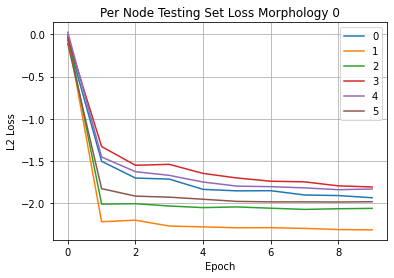

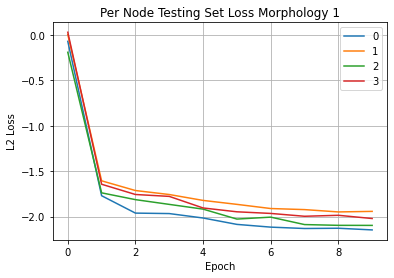

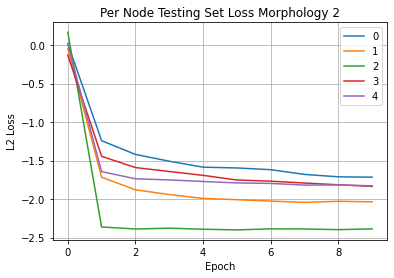

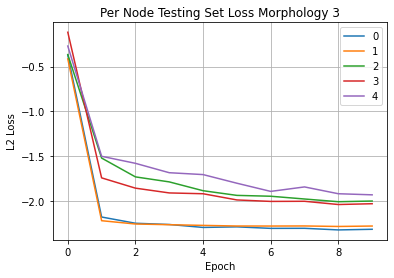

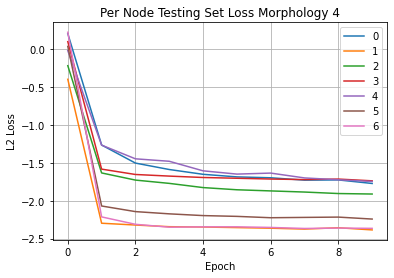

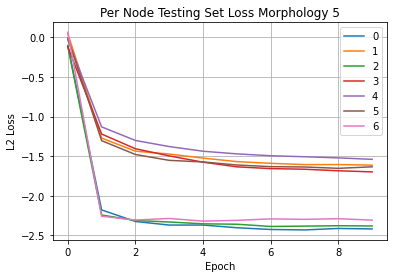

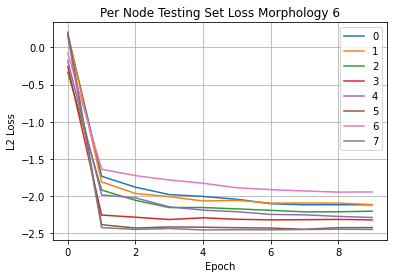

In [24]:
# Cell for producing Per Node Loss for each Morphology

for morphIdx in range(7):
    if morphIdx in trainingIdxs:
        lossArr = torch.stack(testLosses[morphIdx]).T
        np.save('per-node-lossArr-{}'.format(morphIdx), lossArr)
        lossArr = np.log10(lossArr)
    else:
        lossArr = torch.stack(validLosses[morphIdx]).T
    fig, ax = plt.subplots(1, sharex=True)
    for i in range(lossArr.shape[0]):
        ax.plot(range(lossArr.shape[1]), lossArr[i])
    plt.legend(range(lossArr.shape[0]))
    plt.xlabel('Epoch')
    plt.grid()
    plt.ylabel('L2 Loss')
    plt.title('Per Node Testing Set Loss Morphology {}'.format(morphIdx, morphIdx in trainingIdxs))
    plt.savefig('per-node-loss-{}.jpg'.format(morphIdx))
    plt.show()
    

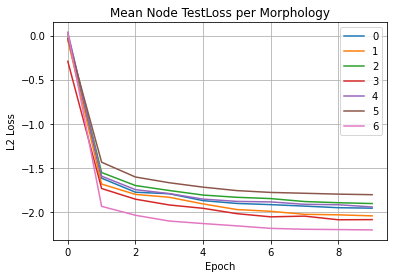

In [20]:
fig, ax = plt.subplots(1, sharex=True)
for morphIdx in trainingIdxs:
    lossArr = np.log10(torch.stack(testLosses[morphIdx]).mean(dim=1))
    ax.plot(range(lossArr.shape[0]), lossArr)
for morphIdx in validationIdxs:
    lossArr = torch.stack(validLosses[morphIdx]).mean(dim=1)
    ax.plot(range(lossArr.shape[0]), lossArr)

plt.xlabel('Epoch')
plt.ylabel('L2 Loss')
plt.title('Mean Node TestLoss per Morphology')
plt.grid(True)
plt.legend(trainingIdxs + validationIdxs)
plt.savefig('mean-node-losses.jpg')
plt.show()

In [23]:
torch.save(gnn.state_dict(), 'inverseModel-GNN.pt')

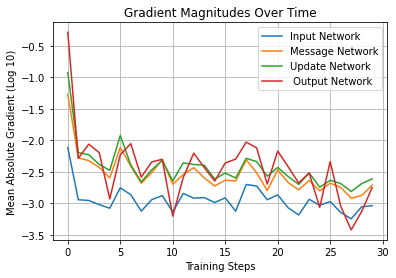

In [22]:
fig, ax = plt.subplots(1, sharex=True)
ax.plot(range(len(inputNetworkGradients)), np.log10(inputNetworkGradients))
ax.plot(range(len(messageNetworkGradients)), np.log10(messageNetworkGradients))
ax.plot(range(len(updateNetworkGradients)), np.log10(updateNetworkGradients))
ax.plot(range(len(outputNetworkGradients)), np.log10(outputNetworkGradients))
plt.xlabel('Training Steps')
plt.ylabel('Mean Absolute Gradient (Log 10)')
plt.title('Gradient Magnitudes Over Time')
plt.grid(True)
plt.legend(['Input Network', 'Message Network', 'Update Network', ' Output Network'])
plt.savefig('gradients.jpg')
plt.show()